## What's next

So you have gone to your team and shown them your estimate of the median ages of billionaires. They are pretty happy with the results, but they want to know some more information. They are interested when these billionaires founded their companies and they want to know what is the 25 percentile oldest companies that billionaire currently have founded.

So they are not just interested in the statistic on the dataset, they are interested as well in what the true population looks like. So that means we need to do bootstrapping.

First step get the data:

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('../data/billionaires.csv')

del df['was founder']
del df['inherited']
del df['from emerging']

df.age.replace(-1, np.NaN, inplace=True)
df.founded.replace(0, np.NaN, inplace=True)
df.gdp.replace(0, np.NaN, inplace=True)

The second step will be to isolate our original sample:

In [5]:
df2014 = df[df.year == 2014]

founded_sample = df2014.founded.dropna()

founded_sample.describe()

count    1641.000000
mean     1963.185253
std        38.071352
min      1615.000000
25%      1948.000000
50%      1973.000000
75%      1991.000000
max      2012.000000
Name: founded, dtype: float64

Then we will draw bootstrap samples from our original sample:

In [6]:
bootstrap_samples = np.random.choice(founded_sample, size=(founded_sample.count(), 9999))

Now we will compute the estimate of interest from each of the samples:

In [8]:
bootstrap_estimates = np.percentile(bootstrap_samples, 25, axis=0)

bootstrap_estimates.shape

(9999,)

Now we plot the distribution:

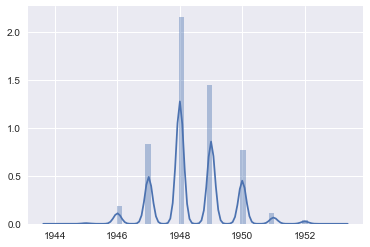

In [9]:
%matplotlib inline
import seaborn as sns

sns.distplot(bootstrap_estimates)

You then go back to your team and show them this distribution. And there are blank stares. They don't know what to draw from it? They just wanted a plausible range for this estimate, and this is where confidence intervals come in. 

## Confidence Intervals

Making the confidence interval is pretty easy, we just remove the most extreme values to the left and the right of the distribution. So if we wanted a 95% confidence interval, then we would remove 2.5% of the values on the right and 2.5% of the values on the left. Let's do that below:

In [10]:
print(np.percentile(bootstrap_estimates, 2.5))
print(np.percentile(bootstrap_estimates, 97.5))

1946.0
1951.0


And this would be our confidence interval. In terms of visualizations, seaborn is quite nice because it will visualize this confidence interval for you if you use certain plots:

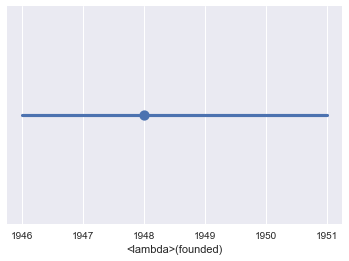

In [16]:
sns.pointplot(founded_sample, ci=95, estimator=lambda x: np.percentile(x, 25))

And if you are lazy you can just use seaborn's bootstrap confidence interval function:

In [24]:
sns_bs = sns.algorithms.bootstrap(founded_sample, func=lambda x: np.percentile(x, 25))

sns_bs.shape

(10000,)

In [25]:
print(np.percentile(sns_bs, 2.5))
print(np.percentile(sns_bs, 97.5))

1946.0
1950.0


## Hypothesis tests

Your team is super happy and can make decisions based on the information that you gave them! Yes! But they come back to you with a final question:

Our hypothesis is that billionaires over the age of 60 have a different net worth than those under that age. Do you think that's right?

This type of question is where hypothesis testing comes in. In a bootstrap hypothesis test you simply look to see the smallest confidence interval that your hypothesis falls into. So if your hypothesis falls into a 75% confidence interval, you can report a p value of .25 (in other words you will reject the hypothesis wrongly 25% of the time). Based on that p value your organization can decide what to do.

Let's start off by getting the appropriate sample:

In [31]:
old_money = df2014[df2014.age > 60]['worth in billions']
young_money = df2014[df2014.age <= 60]['worth in billions']

old_money.shape, young_money.shape

((899,), (691,))

In [32]:
money = df2014[df2014.age > 60]['worth in billions']
young_money = df2014[df2014.age <= 60]['worth in billions']

old_money.shape, young_money.shape

# we then bootstrap on both
old_bs = sns.algorithms.bootstrap(old_money)
young_bs = sns.algorithms.bootstrap(young_money)

old_bs.shape, young_bs.shape

((10000,), (10000,))

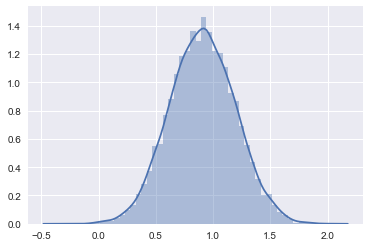

In [33]:
# Then we subtract the both from each other
old_minus_young = old_bs - young_bs

sns.distplot(old_minus_young)

Okay, the above is our bootstrap sampling distribution of the mean net worth of old minus young billionaires. If they had the same net worth then subtracting one from another would yeild a distribution centered at 0. We can see above that this is not true, but how not true is it. Well let's find the smallest confidence interval that our hypothesis of 0 fits in:

In [34]:
# We multiply by two because we need to account for the area on the other side of the interval
(old_minus_young < 0).mean() * 2

0.0016000000000000001

## A warning

The above value is our p value. And we can say that if we reject this hypothesis we will only be wrong .16% of the time. Pretty good right?

There is one thing that needs to be said before we end our lesson here, and that is to mention black swans. We know from our previous analysis that worth in billions has a long right tail, and is a power law distribution. A single person can shift the average. For example it would not be impossible that one person had 500 billion dollars, and if they were included in the young populaiton, then the mean would shift by 1 billion dollars. Crazy right. Because this type of event is possible we need to be sure to alert people that use this data that an event like this may happen. This type of event on the other hand could not have happened with age (nobody can be 500 years old).